# Multi-Window Diffusion Model Analysis

This notebook provides comprehensive visualization and analysis of diffusion model results across different prediction windows (1, 2, 3, 5, 10, 15 frames).

## Features:
- Temporal evolution analysis with polar plots
- Performance comparison across prediction windows
- Uncertainty quantification from multiple generations
- Condition frame vs prediction frame analysis
- Performance metrics (MSE, SSIM, etc.)


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import json
from pathlib import Path
import random
from scipy.interpolate import griddata
from scipy.stats import pearsonr
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from skimage.metrics import structural_similarity as ssim
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

## Configuration and Data Loading

In [18]:
# Configuration - Update these paths to match your generation results
RESULTS_DIRS = {
    1:  "/mnt/nas05/data01/francesco/progetto_simone/ionosphere/generated_data/generation_results_1frame",
    2:  "/mnt/nas05/data01/francesco/progetto_simone/ionosphere/generated_data/generation_results_2frame", 
    3:  "/mnt/nas05/data01/francesco/progetto_simone/ionosphere/generated_data/generation_results_3frame",
    5:  "/mnt/nas05/data01/francesco/progetto_simone/ionosphere/generated_data/generation_results_5frame",
    10: "/mnt/nas05/data01/francesco/progetto_simone/ionosphere/generated_data/generation_results_10frame",
    15: "/mnt/nas05/data01/francesco/progetto_simone/ionosphere/generated_data/generation_results_15frame"
}

# Normalization factor from your dataset
NORMALIZATION_FACTOR = 108154.0

# Number of conditioning frames
CONDITIONING_FRAMES = 15

print("Available prediction windows:", list(RESULTS_DIRS.keys()))
print(f"Conditioning frames: {CONDITIONING_FRAMES}")

Available prediction windows: [1, 2, 3, 5, 10, 15]
Conditioning frames: 15


In [19]:
def load_sample_data(results_dir, sample_idx):
    """Load all data for a specific sample."""
    sample_dir = Path(results_dir) / f"sample_{sample_idx:04d}"
    
    if not sample_dir.exists():
        return None
    
    data = {}
    
    # Load arrays
    data['conditioning_input'] = np.load(sample_dir / "conditioning_input.npy")
    data['ground_truth'] = np.load(sample_dir / "ground_truth_frames.npy")
    data['generated_samples'] = np.load(sample_dir / "generated_samples.npy")
    data['generated_mean'] = np.load(sample_dir / "generated_mean.npy")
    data['generated_std'] = np.load(sample_dir / "generated_std.npy")
    data['conditions_original'] = np.load(sample_dir / "condition_labels_original.npy")
    
    # Load metadata
    with open(sample_dir / "metadata.json", 'r') as f:
        data['metadata'] = json.load(f)
    
    return data

def get_available_samples(results_dir):
    """Get list of available sample indices in results directory."""
    results_path = Path(results_dir)
    if not results_path.exists():
        return []
    
    sample_dirs = [d for d in results_path.iterdir() if d.is_dir() and d.name.startswith('sample_')]
    sample_indices = [int(d.name.split('_')[1]) for d in sample_dirs]
    return sorted(sample_indices)

# Test data loading
print("Testing data loading...")
for pred_window, results_dir in RESULTS_DIRS.items():
    available_samples = get_available_samples(results_dir)
    print(f"Prediction window {pred_window:2d}: {len(available_samples)} samples available")
    if available_samples:
        test_data = load_sample_data(results_dir, available_samples[0])
        if test_data:
            print(f"  Sample 0 shapes: cond={test_data['conditioning_input'].shape}, "
                  f"gt={test_data['ground_truth'].shape}, gen={test_data['generated_samples'].shape}")

Testing data loading...
Prediction window  1: 100 samples available
  Sample 0 shapes: cond=(15, 24, 360), gt=(1, 24, 360), gen=(5, 1, 24, 360)
Prediction window  2: 100 samples available
  Sample 0 shapes: cond=(15, 24, 360), gt=(2, 24, 360), gen=(5, 2, 24, 360)
Prediction window  3: 100 samples available
  Sample 0 shapes: cond=(15, 24, 360), gt=(3, 24, 360), gen=(5, 3, 24, 360)
Prediction window  5: 100 samples available
  Sample 0 shapes: cond=(15, 24, 360), gt=(5, 24, 360), gen=(5, 5, 24, 360)
Prediction window 10: 100 samples available
  Sample 0 shapes: cond=(15, 24, 360), gt=(10, 24, 360), gen=(5, 10, 24, 360)
Prediction window 15: 100 samples available
  Sample 0 shapes: cond=(15, 24, 360), gt=(15, 24, 360), gen=(5, 15, 24, 360)


## Utility Functions for Visualization

In [20]:
def revert_normalization(data_normalized):
    """Revert normalization to original scale."""
    return data_normalized * NORMALIZATION_FACTOR

def create_polar_plot_data(data):
    """Convert ionosphere data to polar coordinates for plotting."""
    # Handle single channel data
    if data.ndim > 2:
        data = data.squeeze()
    
    # Define coordinates
    mag_lat = np.linspace(-90, -66, data.shape[0])  # 24 latitude points
    mag_lon = np.linspace(0, 360, data.shape[1], endpoint=False)  # 360 longitude points
    
    # Create meshgrid from lat/lon
    lon_grid, lat_grid = np.meshgrid(mag_lon, mag_lat)
    
    # Convert to polar coordinates
    r = 90 - np.abs(lat_grid.flatten())
    theta = np.deg2rad(lon_grid.flatten())
    
    # Interpolate onto regular polar grid
    r_i = np.linspace(r.min(), r.max(), 100)
    theta_i = np.linspace(0, 2 * np.pi, 180)
    r_grid, theta_grid = np.meshgrid(r_i, theta_i)
    
    # Interpolation for data
    points = np.column_stack((r, theta))
    grid_values = griddata(points, data.flatten(), (r_grid, theta_grid), method='linear')
    
    return theta_grid, r_grid, grid_values

def plot_polar_ionosphere(ax, data, title, vmin=None, vmax=None, cmap='plasma'):
    """Plot ionosphere data in polar coordinates on given axis."""
    theta_grid, r_grid, grid_values = create_polar_plot_data(data)
    
    c = ax.pcolormesh(theta_grid, r_grid, grid_values, shading='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_theta_zero_location("S")
    ax.set_theta_direction(-1)
    ax.set_title(title, fontsize=10)
    
    return c

def calculate_metrics(pred, true):
    """Calculate various performance metrics."""
    # Flatten arrays for metric calculation
    pred_flat = pred.flatten()
    true_flat = true.flatten()
    
    metrics = {
        'mse': mean_squared_error(true_flat, pred_flat),
        'mae': mean_absolute_error(true_flat, pred_flat),
        'rmse': np.sqrt(mean_squared_error(true_flat, pred_flat)),
        'correlation': pearsonr(true_flat, pred_flat)[0],
        'max_diff': np.max(np.abs(true_flat - pred_flat)),
        'mean_diff': np.mean(true_flat - pred_flat)
    }
    
    # SSIM for 2D images
    if pred.ndim >= 2:
        try:
            metrics['ssim'] = ssim(true.squeeze(), pred.squeeze(), data_range=true.max() - true.min())
        except:
            metrics['ssim'] = np.nan
    
    return metrics

print("Utility functions loaded successfully!")

Utility functions loaded successfully!


## Detailed Performance Comparison

In [24]:
def compare_all_models_performance(max_samples=10):
    """
    Compare performance across all prediction windows for multiple samples.
    """
    print(f"🔍 COMPREHENSIVE MODEL COMPARISON")
    print(f"{'='*60}")
    
    # Collect performance data
    performance_data = []
    
    # Get common samples across all models
    common_samples = None
    for pred_window, results_dir in RESULTS_DIRS.items():
        available_samples = get_available_samples(results_dir)
        if common_samples is None:
            common_samples = set(available_samples)
        else:
            common_samples = common_samples.intersection(set(available_samples))
    
    common_samples = sorted(list(common_samples))[:max_samples]
    print(f"📊 Analyzing {len(common_samples)} common samples: {common_samples}")
    
    for sample_idx in tqdm(common_samples, desc="Processing samples"):
        for pred_window, results_dir in RESULTS_DIRS.items():
            data = load_sample_data(results_dir, sample_idx)
            if data is None:
                continue
            
            pred_mean = revert_normalization(data['generated_mean'])
            gt = revert_normalization(data['ground_truth'])
            std_data = revert_normalization(data['generated_std'])
            
            # Calculate metrics for each prediction frame
            for frame_idx in range(min(pred_mean.shape[0], gt.shape[0])):
                metrics = calculate_metrics(pred_mean[frame_idx], gt[frame_idx])
                metrics['uncertainty_mean'] = std_data[frame_idx].mean()
                metrics['uncertainty_max'] = std_data[frame_idx].max()
                
                performance_data.append({
                    'sample_idx': sample_idx,
                    'prediction_window': pred_window,
                    'frame_idx': frame_idx,
                    'timestep': CONDITIONING_FRAMES + frame_idx,
                    **metrics
                })
    
    # Convert to DataFrame for analysis
    df = pd.DataFrame(performance_data)
    
    print(f"📈 Collected {len(df)} data points")
    print(f"🎯 Prediction windows: {sorted(df['prediction_window'].unique())}")
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle('Comprehensive Model Performance Comparison', fontsize=16)
    
    # Plot 1: MSE vs Prediction Window (First frame only)
    df_first_frame = df[df['frame_idx'] == 0]
    
    ax = axes[0, 0]
    sns.boxplot(data=df_first_frame, x='prediction_window', y='mse', ax=ax)
    ax.set_title('MSE vs Prediction Window\n(First Prediction Frame)')
    ax.set_ylabel('MSE')
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Correlation vs Prediction Window
    ax = axes[0, 1]
    sns.boxplot(data=df_first_frame, x='prediction_window', y='correlation', ax=ax)
    ax.set_title('Correlation vs Prediction Window\n(First Prediction Frame)')
    ax.set_ylabel('Correlation')
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Uncertainty vs Prediction Window
    ax = axes[0, 2]
    sns.boxplot(data=df_first_frame, x='prediction_window', y='uncertainty_mean', ax=ax)
    ax.set_title('Uncertainty vs Prediction Window\n(First Prediction Frame)')
    ax.set_ylabel('Mean Uncertainty (Std Dev)')
    ax.grid(True, alpha=0.3)
    
    # Plot 4: Performance degradation over frames (for multi-frame models)
    ax = axes[1, 0]
    multi_frame_windows = df[df['prediction_window'] > 1]['prediction_window'].unique()
    for window in sorted(multi_frame_windows):
        window_data = df[df['prediction_window'] == window]
        frame_means = window_data.groupby('frame_idx')['mse'].mean()
        ax.plot(frame_means.index, frame_means.values, 'o-', label=f'Window {window}', linewidth=2)
    
    ax.set_xlabel('Prediction Frame Index')
    ax.set_ylabel('MSE')
    ax.set_title('MSE Degradation Over Prediction Frames')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 5: Correlation degradation over frames
    ax = axes[1, 1]
    for window in sorted(multi_frame_windows):
        window_data = df[df['prediction_window'] == window]
        frame_means = window_data.groupby('frame_idx')['correlation'].mean()
        ax.plot(frame_means.index, frame_means.values, 'o-', label=f'Window {window}', linewidth=2)
    
    ax.set_xlabel('Prediction Frame Index')
    ax.set_ylabel('Correlation')
    ax.set_title('Correlation Degradation Over Prediction Frames')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 6: Uncertainty evolution over frames
    ax = axes[1, 2]
    for window in sorted(multi_frame_windows):
        window_data = df[df['prediction_window'] == window]
        frame_means = window_data.groupby('frame_idx')['uncertainty_mean'].mean()
        ax.plot(frame_means.index, frame_means.values, 'o-', label=f'Window {window}', linewidth=2)
    
    ax.set_xlabel('Prediction Frame Index')
    ax.set_ylabel('Mean Uncertainty')
    ax.set_title('Uncertainty Evolution Over Prediction Frames')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 7: SSIM vs Prediction Window
    ax = axes[2, 0]
    df_valid_ssim = df_first_frame[df_first_frame['ssim'].notna()]
    if len(df_valid_ssim) > 0:
        sns.boxplot(data=df_valid_ssim, x='prediction_window', y='ssim', ax=ax)
        ax.set_title('SSIM vs Prediction Window\n(First Prediction Frame)')
        ax.set_ylabel('SSIM')
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'SSIM data not available', ha='center', va='center', transform=ax.transAxes)
        ax.set_title('SSIM vs Prediction Window')
    
    # Plot 8: Performance summary table
    ax = axes[2, 1]
    ax.axis('off')
    
    # Create summary statistics
    summary_stats = df_first_frame.groupby('prediction_window').agg({
        'mse': ['mean', 'std'],
        'correlation': ['mean', 'std'],
        'uncertainty_mean': ['mean', 'std']
    }).round(4)
    
    table_data = []
    for window in sorted(df_first_frame['prediction_window'].unique()):
        mse_mean = summary_stats.loc[window, ('mse', 'mean')]
        mse_std = summary_stats.loc[window, ('mse', 'std')]
        corr_mean = summary_stats.loc[window, ('correlation', 'mean')]
        corr_std = summary_stats.loc[window, ('correlation', 'std')]
        unc_mean = summary_stats.loc[window, ('uncertainty_mean', 'mean')]
        unc_std = summary_stats.loc[window, ('uncertainty_mean', 'std')]
        
        table_data.append([
            f"W{int(window)}",
            f"{mse_mean:.2f}±{mse_std:.2f}",
            f"{corr_mean:.3f}±{corr_std:.3f}",
            f"{unc_mean:.2f}±{unc_std:.2f}"
        ])
    
    table = ax.table(cellText=table_data,
                    colLabels=['Window', 'MSE', 'Correlation', 'Uncertainty'],
                    cellLoc='center',
                    loc='center',
                    bbox=[0, 0, 1, 1])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    ax.set_title('Performance Summary Table\n(Mean ± Std)')
    
    # Plot 9: Sample variance across models
    ax = axes[2, 2]
    sample_variance = df_first_frame.groupby('sample_idx')['mse'].std()
    ax.hist(sample_variance, bins=10, alpha=0.7)
    ax.set_xlabel('MSE Standard Deviation Across Models')
    ax.set_ylabel('Frequency')
    ax.set_title('Sample-wise Performance Variance')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return df, summary_stats

print("Performance comparison function ready!")

Performance comparison function ready!


🚀 Starting comprehensive performance comparison...
🔍 COMPREHENSIVE MODEL COMPARISON
📊 Analyzing 20 common samples: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


Processing samples: 100%|██████████| 20/20 [00:03<00:00,  5.23it/s]


📈 Collected 720 data points
🎯 Prediction windows: [1, 2, 3, 5, 10, 15]


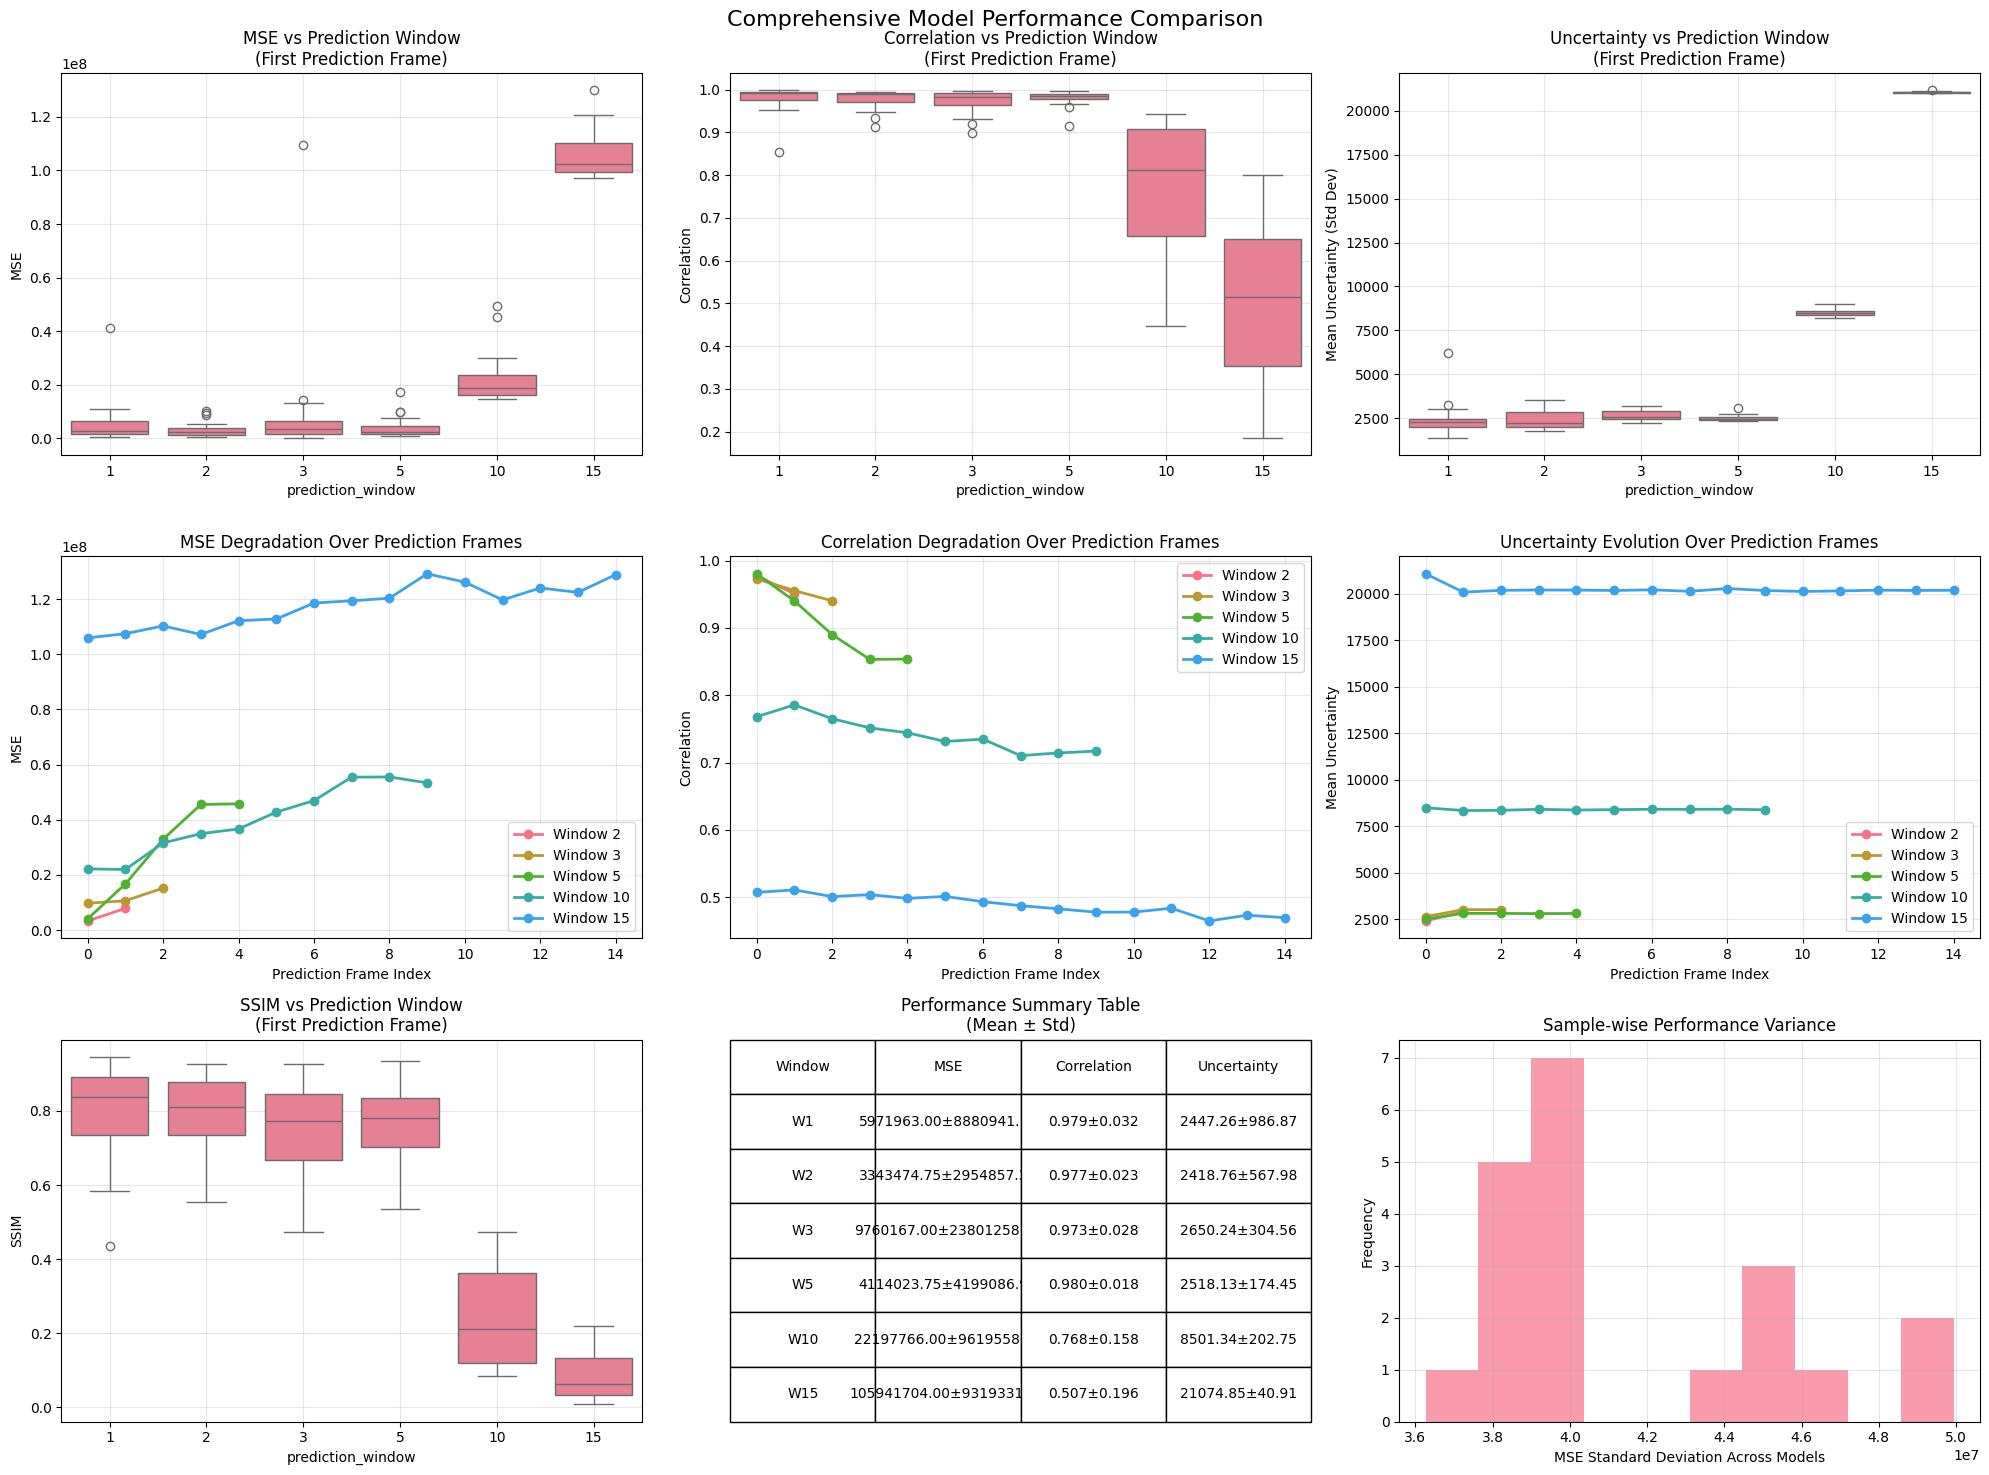

In [25]:
# Run comprehensive performance comparison
print("🚀 Starting comprehensive performance comparison...")
performance_df, summary_statistics = compare_all_models_performance(max_samples=20)

In [ ]:
import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec
import imageio
import os

def generate_comparison_gif(sample_data, pred_window, sample_idx, output_dir="gifs", fps=2):
    """Generate GIF with SEPARATE vmin/vmax for conditioning vs predicted frames."""
    print(f"Generating GIF for Sample {sample_idx}, Window {pred_window}")
    
    os.makedirs(output_dir, exist_ok=True)
    data = sample_data[pred_window]
    
    # Get data
    conditioning_input = revert_normalization(data['conditioning_input'])
    generated_mean = revert_normalization(data['generated_mean'])
    ground_truth = revert_normalization(data['ground_truth'])
    generated_std = revert_normalization(data['generated_std'])
    
    # SEPARATE SCALING AS REQUESTED
    # Conditioning vmin/vmax
    cond_vmin = conditioning_input.min()
    cond_vmax = conditioning_input.max()
    
    # Predicted frames vmin/vmax (sequence-wide for generated)
    pred_vmin = generated_mean.min()
    pred_vmax = generated_mean.max()
    gt_pred_vmin = ground_truth.min() 
    gt_pred_vmax = ground_truth.max()
    
    # Use generated sequence range for predicted frames
    pred_global_vmin = min(pred_vmin, gt_pred_vmin)
    pred_global_vmax = max(pred_vmax, gt_pred_vmax)
    
    print(f"  Conditioning range: [{cond_vmin:.1f}, {cond_vmax:.1f}]")
    print(f"  Predicted range: [{pred_global_vmin:.1f}, {pred_global_vmax:.1f}]")
    
    frames = []
    total_frames = generated_mean.shape[0]
    
    for frame_idx in range(total_frames):
        fig = plt.figure(figsize=(16, 8))
        
        # Generated frame
        ax1 = plt.subplot(1, 4, 1, polar=True)
        c1 = plot_polar_ionosphere(ax1, generated_mean[frame_idx], 
                                   f'Generated F{frame_idx+1}\\nW{pred_window}', 
                                   vmin=pred_global_vmin, vmax=pred_global_vmax)
        plt.colorbar(c1, ax=ax1, shrink=0.6)
        
        # Ground truth frame
        ax2 = plt.subplot(1, 4, 2, polar=True)
        c2 = plot_polar_ionosphere(ax2, ground_truth[frame_idx],
                                   f'GT F{frame_idx+1}\\nW{pred_window}',
                                   vmin=pred_global_vmin, vmax=pred_global_vmax)
        plt.colorbar(c2, ax=ax2, shrink=0.6)
        
        # Uncertainty
        ax3 = plt.subplot(1, 4, 3, polar=True)
        c3 = plot_polar_ionosphere(ax3, generated_std[frame_idx],
                                   f'Uncertainty\\nF{frame_idx+1}',
                                   vmin=0, vmax=generated_std.max(), cmap='Reds')
        plt.colorbar(c3, ax=ax3, shrink=0.6)
        
        # Min-max plot - FIXED FOR SINGLE FRAME
        ax4 = plt.subplot(1, 4, 4)
        
        if pred_window == 1:
            # For window 1: show single point
            ax4.scatter([0], [generated_mean[0].min()], color='blue', s=100, label='Gen Min', marker='o')
            ax4.scatter([0], [generated_mean[0].max()], color='blue', s=100, label='Gen Max', marker='^')
            ax4.scatter([0], [ground_truth[0].min()], color='red', s=100, label='GT Min', marker='o')
            ax4.scatter([0], [ground_truth[0].max()], color='red', s=100, label='GT Max', marker='^')
            ax4.set_xlim(-0.5, 0.5)
            ax4.set_xticks([0])
            ax4.set_xticklabels(['F1'])
        else:
            # For multi-frame: show lines up to current frame
            frame_indices = np.arange(frame_idx + 1)
            gen_mins = [generated_mean[i].min() for i in frame_indices]
            gen_maxs = [generated_mean[i].max() for i in frame_indices]
            gt_mins = [ground_truth[i].min() for i in frame_indices]
            gt_maxs = [ground_truth[i].max() for i in frame_indices]
            
            ax4.plot(frame_indices, gen_mins, 'b-', label='Gen Min', linewidth=2, marker='o')
            ax4.plot(frame_indices, gen_maxs, 'b--', label='Gen Max', linewidth=2, marker='^')
            ax4.plot(frame_indices, gt_mins, 'r-', label='GT Min', linewidth=2, marker='o')
            ax4.plot(frame_indices, gt_maxs, 'r--', label='GT Max', linewidth=2, marker='^')
            ax4.axvline(x=frame_idx, color='black', linestyle=':', alpha=0.7)
            ax4.set_xlim(-0.5, max(1, total_frames-0.5))
        
        ax4.set_ylabel('Value')
        ax4.set_title('Min-Max Evolution')
        ax4.legend(fontsize=8)
        ax4.grid(True, alpha=0.3)
        
        plt.suptitle(f'Sample {sample_idx} - Window {pred_window} - Frame {frame_idx+1}/{total_frames}', fontsize=14)
        plt.tight_layout()
        
        # Save frame
        frame_filename = f"/tmp/frame_{frame_idx:03d}.png"
        plt.savefig(frame_filename, dpi=100, bbox_inches='tight')
        frames.append(frame_filename)
        plt.close()
    
    # Create GIF
    gif_filename = f"{output_dir}/sample_{sample_idx:04d}_window_{pred_window:02d}.gif"
    duration_ms = int(1000 / fps)
    
    with imageio.get_writer(gif_filename, mode='I', duration=duration_ms, loop=0) as writer:
        for frame_file in frames:
            image = imageio.imread(frame_file)
            writer.append_data(image)
            os.remove(frame_file)
    
    print(f"  ✅ Saved: {gif_filename}")
    return gif_filename

print("✅ FIXED GIF generation ready!")


📊 Running comprehensive horizon comparison...
📊 COMPREHENSIVE HORIZON COMPARISON - Sample 5
📈 Available windows: [1, 2, 3, 5, 10, 15]
📊 Comprehensive comparison saved: comprehensive_horizon_comparison_sample_0005.png


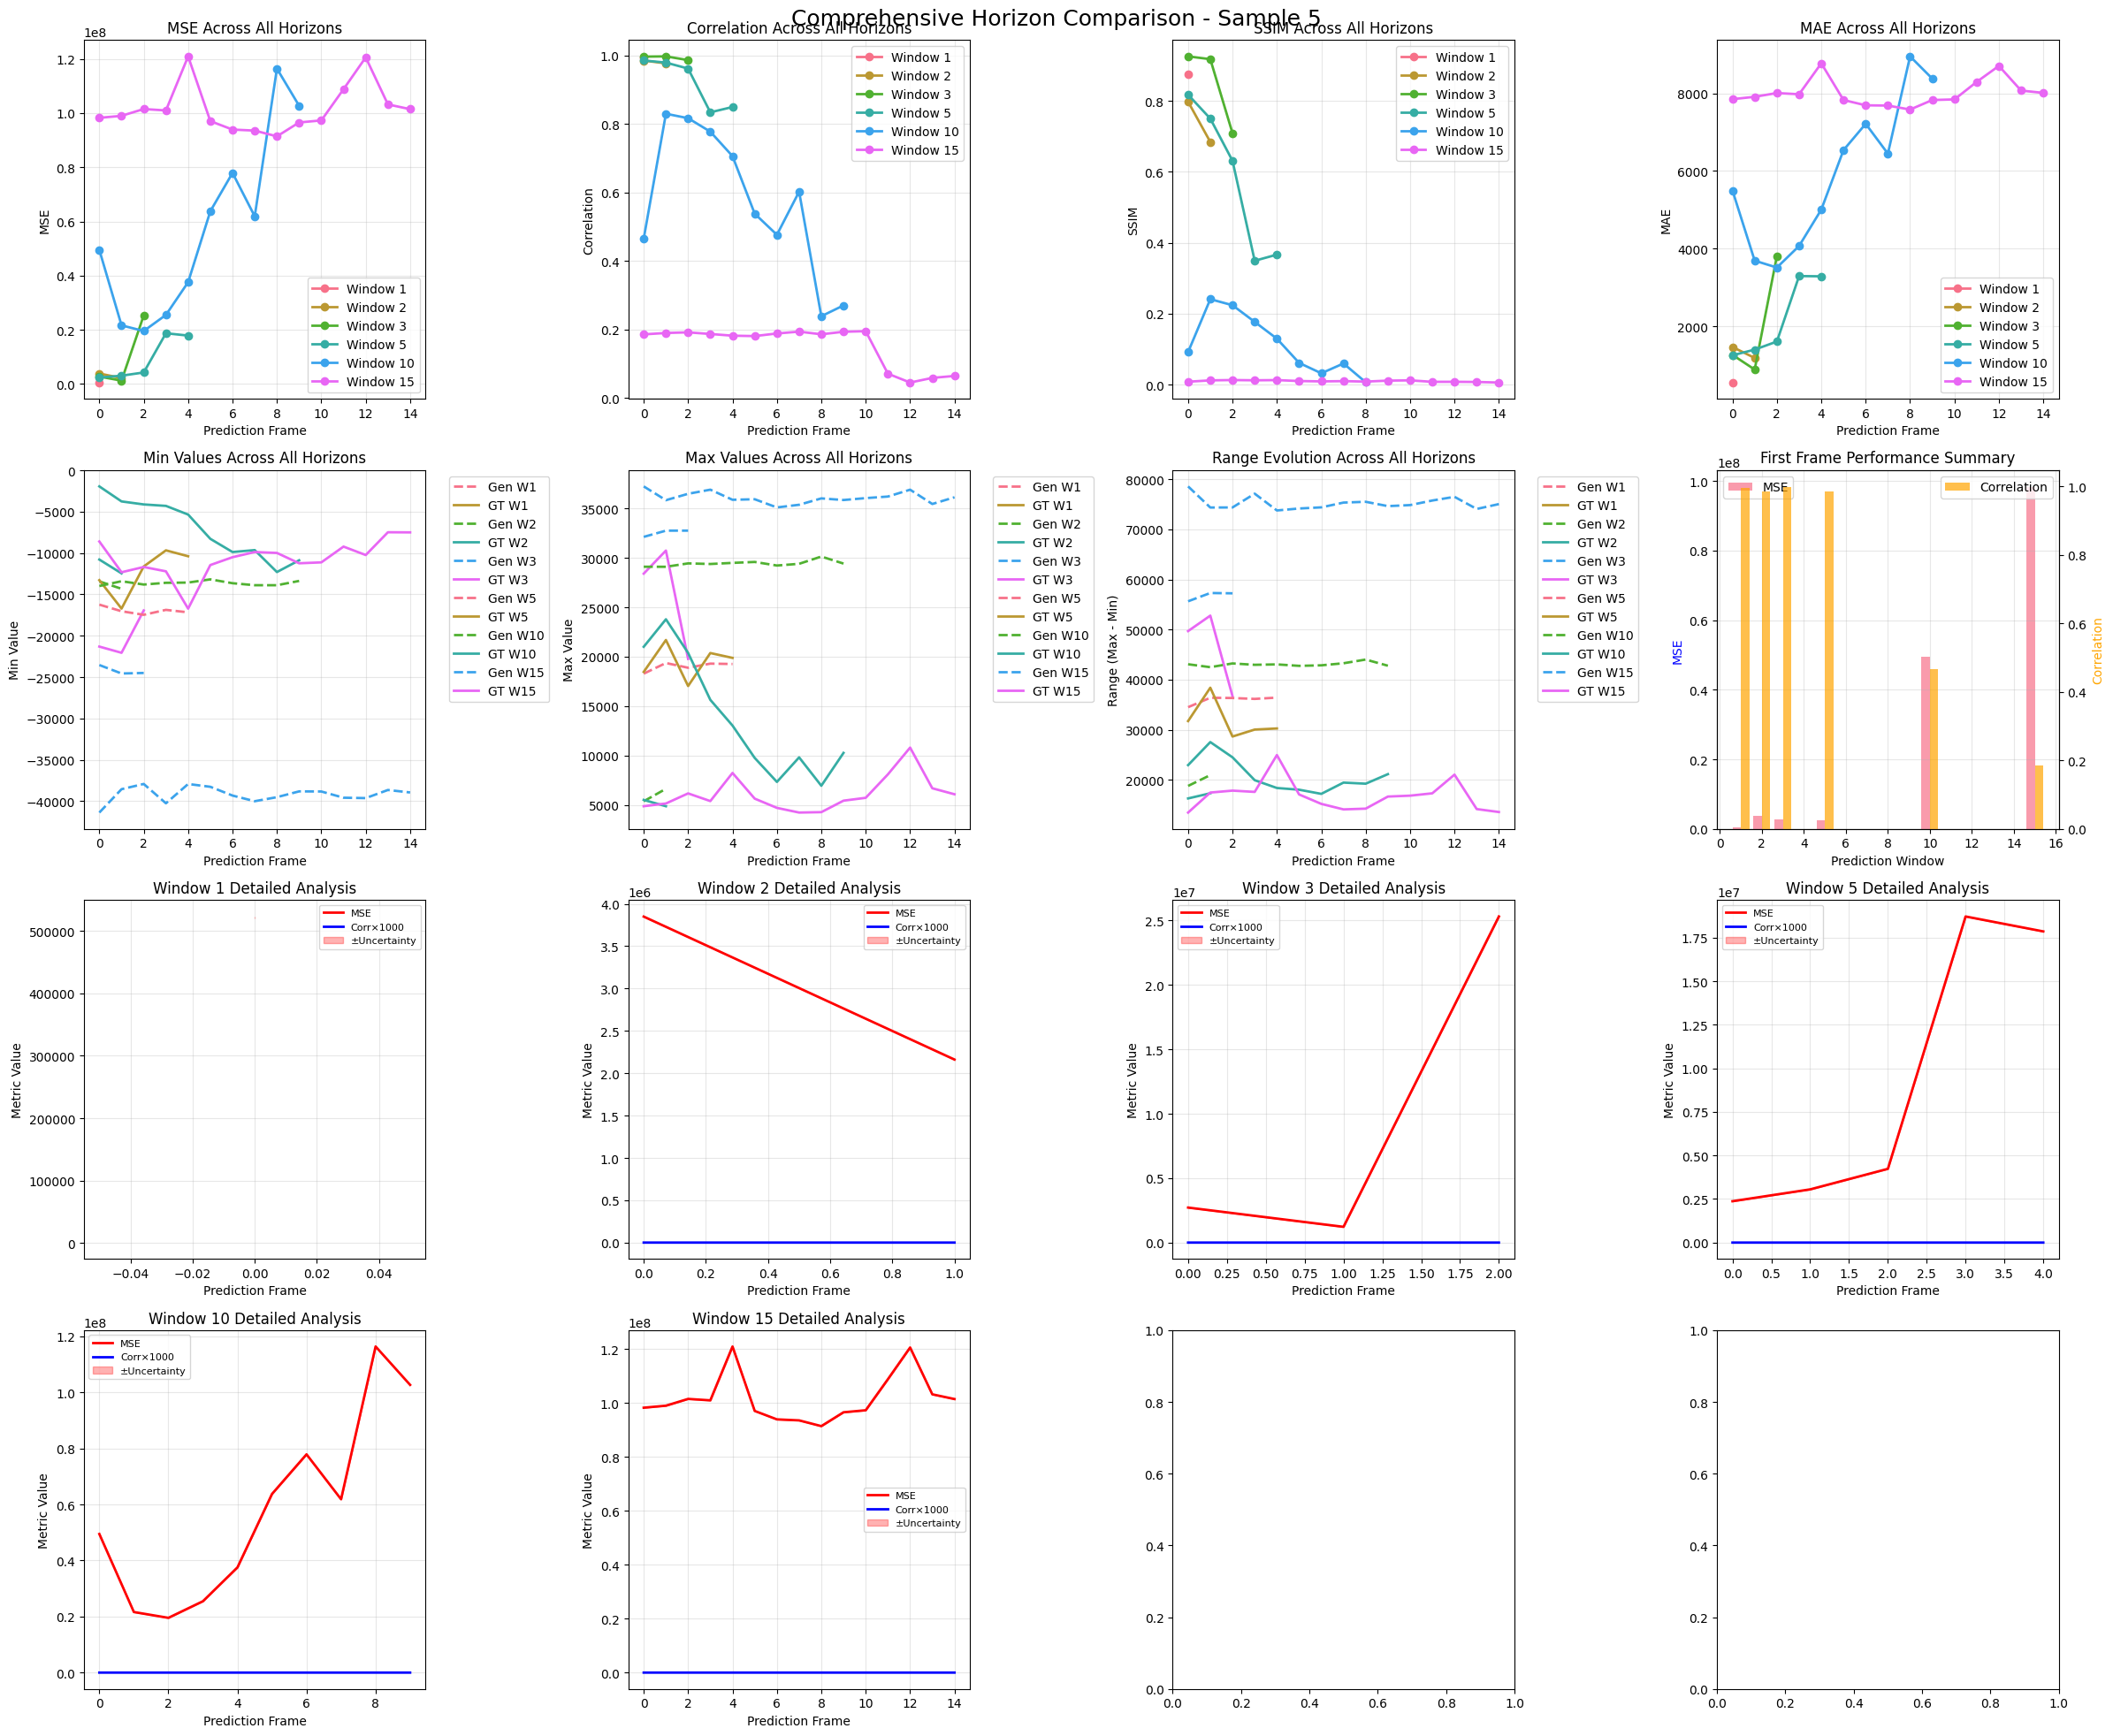

In [15]:
# Run comprehensive horizon comparison
print("\n📊 Running comprehensive horizon comparison...")
target_sample = 5
comparison_results = comprehensive_horizon_comparison(sample_idx=target_sample, save_plots=True)

## 🎬 Generate GIFs and Run Enhanced Analysis

In [22]:
def comprehensive_horizon_comparison(sample_idx=0, save_plots=True):
    """
    Comprehensive comparison across all horizon windows for all metrics.
    """
    print(f"📊 COMPREHENSIVE HORIZON COMPARISON - Sample {sample_idx}")
    print(f"{'='*70}")
    
    # Load data for all prediction windows
    all_sample_data = {}
    for pred_window in RESULTS_DIRS.keys():
        data = load_sample_data(RESULTS_DIRS[pred_window], sample_idx)
        if data is not None:
            all_sample_data[pred_window] = data
    
    if not all_sample_data:
        print("❌ No data found for the specified sample!")
        return None
    
    available_windows = sorted(all_sample_data.keys())
    print(f"📈 Available windows: {available_windows}")
    
    # Create comprehensive comparison figure
    fig, axes = plt.subplots(4, 4, figsize=(24, 20))
    fig.suptitle(f'Comprehensive Horizon Comparison - Sample {sample_idx}', fontsize=18)
    
    # Collect all metrics for each window
    all_metrics = {}
    minmax_data = {}
    
    for pred_window in available_windows:
        data = all_sample_data[pred_window]
        generated_mean = revert_normalization(data['generated_mean'])
        ground_truth = revert_normalization(data['ground_truth'])
        
        # Track min-max evolution
        minmax_data[pred_window] = track_minmax_evolution(all_sample_data, pred_window, sample_idx)
        
        # Calculate metrics for each frame
        window_metrics = {'frames': [], 'mse': [], 'correlation': [], 'ssim': [], 'mae': []}
        
        for frame_idx in range(min(generated_mean.shape[0], ground_truth.shape[0])):
            metrics = calculate_metrics(generated_mean[frame_idx], ground_truth[frame_idx])
            window_metrics['frames'].append(frame_idx)
            window_metrics['mse'].append(metrics['mse'])
            window_metrics['correlation'].append(metrics['correlation'])
            window_metrics['ssim'].append(metrics['ssim'] if not np.isnan(metrics['ssim']) else 0)
            window_metrics['mae'].append(metrics['mae'])
        
        all_metrics[pred_window] = window_metrics
    
    # Plot 1: MSE comparison across horizons
    ax = axes[0, 0]
    for pred_window in available_windows:
        metrics = all_metrics[pred_window]
        ax.plot(metrics['frames'], metrics['mse'], 'o-', label=f'Window {pred_window}', linewidth=2)
    ax.set_xlabel('Prediction Frame')
    ax.set_ylabel('MSE')
    ax.set_title('MSE Across All Horizons')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Correlation comparison
    ax = axes[0, 1]
    for pred_window in available_windows:
        metrics = all_metrics[pred_window]
        ax.plot(metrics['frames'], metrics['correlation'], 'o-', label=f'Window {pred_window}', linewidth=2)
    ax.set_xlabel('Prediction Frame')
    ax.set_ylabel('Correlation')
    ax.set_title('Correlation Across All Horizons')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 3: SSIM comparison
    ax = axes[0, 2]
    for pred_window in available_windows:
        metrics = all_metrics[pred_window]
        valid_ssim = [s for s in metrics['ssim'] if s > 0]
        if valid_ssim:
            ax.plot(metrics['frames'][:len(valid_ssim)], valid_ssim, 'o-', label=f'Window {pred_window}', linewidth=2)
    ax.set_xlabel('Prediction Frame')
    ax.set_ylabel('SSIM')
    ax.set_title('SSIM Across All Horizons')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 4: MAE comparison  
    ax = axes[0, 3]
    for pred_window in available_windows:
        metrics = all_metrics[pred_window]
        ax.plot(metrics['frames'], metrics['mae'], 'o-', label=f'Window {pred_window}', linewidth=2)
    ax.set_xlabel('Prediction Frame')
    ax.set_ylabel('MAE')
    ax.set_title('MAE Across All Horizons')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 5: Min values evolution
    ax = axes[1, 0]
    for pred_window in available_windows:
        minmax = minmax_data[pred_window]
        ax.plot(minmax['frame_indices'], minmax['gen_mins'], '--', label=f'Gen W{pred_window}', linewidth=2)
        ax.plot(minmax['frame_indices'], minmax['gt_mins'], '-', label=f'GT W{pred_window}', linewidth=2)
    ax.set_xlabel('Prediction Frame')
    ax.set_ylabel('Min Value')
    ax.set_title('Min Values Across All Horizons')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    
    # Plot 6: Max values evolution
    ax = axes[1, 1]
    for pred_window in available_windows:
        minmax = minmax_data[pred_window]
        ax.plot(minmax['frame_indices'], minmax['gen_maxs'], '--', label=f'Gen W{pred_window}', linewidth=2)
        ax.plot(minmax['frame_indices'], minmax['gt_maxs'], '-', label=f'GT W{pred_window}', linewidth=2)
    ax.set_xlabel('Prediction Frame')
    ax.set_ylabel('Max Value')
    ax.set_title('Max Values Across All Horizons')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    
    # Plot 7: Range evolution (max - min)
    ax = axes[1, 2]
    for pred_window in available_windows:
        minmax = minmax_data[pred_window]
        ax.plot(minmax['frame_indices'], minmax['gen_ranges'], '--', label=f'Gen W{pred_window}', linewidth=2)
        ax.plot(minmax['frame_indices'], minmax['gt_ranges'], '-', label=f'GT W{pred_window}', linewidth=2)
    ax.set_xlabel('Prediction Frame')
    ax.set_ylabel('Range (Max - Min)')
    ax.set_title('Range Evolution Across All Horizons')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    
    # Plot 8: First frame performance summary
    ax = axes[1, 3]
    first_frame_mse = [all_metrics[w]['mse'][0] for w in available_windows]
    first_frame_corr = [all_metrics[w]['correlation'][0] for w in available_windows]
    
    ax_twin = ax.twinx()
    bars1 = ax.bar([w - 0.2 for w in available_windows], first_frame_mse, 0.4, label='MSE', alpha=0.7)
    bars2 = ax_twin.bar([w + 0.2 for w in available_windows], first_frame_corr, 0.4, label='Correlation', alpha=0.7, color='orange')
    
    ax.set_xlabel('Prediction Window')
    ax.set_ylabel('MSE', color='blue')
    ax_twin.set_ylabel('Correlation', color='orange')
    ax.set_title('First Frame Performance Summary')
    ax.legend(loc='upper left')
    ax_twin.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Plot 9-16: Individual window detailed analysis
    for i, pred_window in enumerate(available_windows):
        if i >= 8:  # Limit to 8 detailed plots
            break
        
        row = 2 + i // 4
        col = i % 4
        ax = axes[row, col]
        
        # Get data for this specific window
        data = all_sample_data[pred_window]
        generated_mean = revert_normalization(data['generated_mean'])
        ground_truth = revert_normalization(data['ground_truth'])
        generated_std = revert_normalization(data['generated_std'])
        
        # Plot metrics evolution with uncertainty
        metrics = all_metrics[pred_window]
        ax.plot(metrics['frames'], metrics['mse'], 'r-', label='MSE', linewidth=2)
        ax.plot(metrics['frames'], np.array(metrics['correlation']) * 1000, 'b-', label='Corr×1000', linewidth=2)  # Scale for visibility
        
        # Add uncertainty shading
        uncertainty_means = [generated_std[f].mean() for f in range(len(metrics['frames']))]
        ax.fill_between(metrics['frames'], 
                       np.array(metrics['mse']) - np.array(uncertainty_means),
                       np.array(metrics['mse']) + np.array(uncertainty_means),
                       alpha=0.3, color='red', label='±Uncertainty')
        
        ax.set_xlabel('Prediction Frame')
        ax.set_ylabel('Metric Value')
        ax.set_title(f'Window {pred_window} Detailed Analysis')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save_plots:
        plot_filename = f"comprehensive_horizon_comparison_sample_{sample_idx:04d}.png"
        plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
        print(f"📊 Comprehensive comparison saved: {plot_filename}")
    
    plt.show()
    
    return {
        'sample_idx': sample_idx,
        'available_windows': available_windows,
        'all_metrics': all_metrics,
        'minmax_data': minmax_data
    }

print("📊 Comprehensive horizon comparison function ready!")

📊 Comprehensive horizon comparison function ready!


In [23]:
# SIMPLE GIF GENERATION SCRIPT - RUN THIS CELL
target_sample = 5  

# Load sample data
sample_data = {}
for pred_window, results_dir in RESULTS_DIRS.items():
    data = load_sample_data(results_dir, target_sample)
    if data is not None:
        sample_data[pred_window] = data

print(f"Loaded data for windows: {sorted(sample_data.keys())}")

# Generate GIFs for each window
for pred_window in sorted(sample_data.keys()):
    print(f"Generating GIF for window {pred_window}...")
    try:
        gif_file = generate_comparison_gif(sample_data, pred_window, target_sample, 
                                         output_dir="sample_gifs", fps=1)
        print(f"✅ Generated: {gif_file}")
    except Exception as e:
        print(f"❌ Error: {e}")

print("Done!")

Loaded data for windows: [1, 2, 3, 5, 10, 15]
Generating GIF for window 1...
Generating GIF for Sample 5, Window 1
  Conditioning range: [-19702.4, 18487.3]
  Predicted range: [-14439.0, 12782.3]
  ✅ Saved: sample_gifs/sample_0005_window_01.gif
✅ Generated: sample_gifs/sample_0005_window_01.gif
Generating GIF for window 2...
Generating GIF for Sample 5, Window 2
  Conditioning range: [-25365.6, 7489.0]
  Predicted range: [-14325.5, 6632.7]
  ✅ Saved: sample_gifs/sample_0005_window_02.gif
✅ Generated: sample_gifs/sample_0005_window_02.gif
Generating GIF for window 3...
Generating GIF for Sample 5, Window 3
  Conditioning range: [-28519.1, 43860.2]
  Predicted range: [-24560.9, 32752.7]
  ✅ Saved: sample_gifs/sample_0005_window_03.gif
✅ Generated: sample_gifs/sample_0005_window_03.gif
Generating GIF for window 5...
Generating GIF for Sample 5, Window 5
  Conditioning range: [-24345.2, 21515.3]
  Predicted range: [-17468.8, 21688.3]
  ✅ Saved: sample_gifs/sample_0005_window_05.gif
✅ Gener

## 🎬 NEW: GIF Generation and Min-Max Analysis

This section adds the missing features you requested:
1. **Min-Max parameter tracking in predicted frames**
2. **GIF generation for generated vs true data per horizon**  
3. **Proper vmin/vmax scaling based on sequence-wide values**

## Usage Instructions

### To use this notebook:

1. **Update Configuration**: Modify the `RESULTS_DIRS` dictionary to point to your generated results directories

2. **Run Generation Script**: First run the `generate_multi_window.py` script for each model:
   ```bash
   python generate_multi_window.py --model_ckpt model_1.pth --config config_1.json --output_dir results_1_frame/ --num_generations 5
   python generate_multi_window.py --model_ckpt model_2.pth --config config_2.json --output_dir results_2_frame/ --num_generations 5
   # ... etc for all prediction windows
   ```

3. **Analyze Results**: Run the cells in this notebook to get comprehensive visualizations and analysis

### Key Features:

- **Multi-window comparison**: Compare performance across different prediction windows (1, 2, 3, 5, 10, 15)
- **Uncertainty quantification**: Analyze uncertainty from multiple generations per input
- **Polar visualizations**: Beautiful polar plots showing ionosphere data
- **Performance metrics**: MSE, correlation, SSIM, uncertainty measures
- **Temporal analysis**: See how prediction quality degrades over time
- **Interactive exploration**: Analyze specific samples in detail
- **Export capabilities**: Save results to CSV for further analysis

### Expected Results:

You should observe that:
- **Performance degrades** as prediction window increases
- **Uncertainty increases** for longer prediction windows
- **Correlation decreases** for frames further in the future
- **MSE increases** as the model predicts further ahead

This matches the expectation that forecasting becomes more difficult the further you predict into the future.